In [1]:
from labvision import images, video

In [89]:
import numpy as np
import filehandling
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [64]:
def track(vid_filename):
    vid = video.ReadVideo(vid_filename)
    circles = []
    for frame in vid:
        frame = images.bgr_to_gray(frame)
        c = images.find_circles(frame, 800, 200, 9, 300, 320)
        circles.append(c)
    filtered_circles = [filter_circles(c, images.bgr_to_gray(vid.read_frame(i)))
                       if len(c.shape) == 2 else c
                       for i, c in enumerate(circles)]
    circles = np.stack(filtered_circles)
    data = pd.DataFrame({'x': circles[:, 0], 'y': circles[:, 1], 'r': circles[:, 2]})
    data.index = data.index.rename('frame')
    data = tp.link_df(data.reset_index(), 30)
    return data

In [36]:
def filter_circles(cs, f):
    h, w = f.shape
    intensities = []
    for c in cs:
        x, y, r = c
        xmin = int(x-r) if x-r > 0 else 0
        xmax = int(x+r) if x+r < w else w
        ymin = int(y-r) if y-r > 0 else 0
        ymax = int(y+r) if y+r < h else h
        fbox = f[ymin:ymax, xmin:xmax]
        mean = np.mean(fbox)
        intensities.append(np.mean(fbox))
    brightest = np.argmax(intensities)
    return cs[brightest]

In [82]:
flat_files = filehandling.get_directory_filenames("/media/NAS/share/James/HighSpeed/FlatIntruder/*")
dimpled_files = filehandling.get_directory_filenames("/media/NAS/share/James/HighSpeed/DimpledIntruder/*")

In [83]:
flat_files = [d for d in flat_files if d.endswith("0.mp4")]
dimpled_files = [d for d in dimpled_files if d.endswith("0.mp4")]

In [84]:
flat_duties = [int(os.path.split(d)[1][:3]) for d in flat_files]
dimpled_duties = [int(os.path.split(d)[1][:3]) for d in dimpled_files]

In [85]:
flat_data = [track(f) for f in tqdm(flat_files)]
dimpled_data = [track(f) for f in tqdm(dimpled_files)]

100%|██████████| 11/11 [14:33<00:00, 67.10s/it]

Frame 998: 1 trajectories present.


100%|██████████| 11/11 [14:33<00:00, 79.37s/it]


In [91]:
d = flat_data[0]

In [96]:
dr = [tp.relate_frames(d, i, i+1).dr.values[0] for i in range(d.frame.max()-1)]
dr

[6.0827627,
 3.6055512,
 6.4031243,
 5.0,
 4.2426405,
 7.81025,
 5.3851647,
 8.246211,
 9.055386,
 6.4031243,
 6.0,
 2.236068,
 3.6055512,
 7.071068,
 3.6055512,
 8.246211,
 10.0,
 7.0,
 6.4031243,
 10.0,
 5.0,
 2.0,
 3.6055512,
 6.3245554,
 6.3245554,
 5.3851647,
 6.0827627,
 4.1231055,
 7.615773,
 5.0990195,
 4.472136,
 3.1622777,
 4.1231055,
 5.0990195,
 8.246211,
 6.3245554,
 11.18034,
 6.3245554,
 8.062258,
 5.8309517,
 3.6055512,
 7.071068,
 7.28011,
 8.944272,
 11.18034,
 5.656854,
 5.0990195,
 2.828427,
 6.3245554,
 9.219544,
 3.6055512,
 6.0827627,
 3.6055512,
 6.0827627,
 5.656854,
 10.816654,
 6.0827627,
 2.0,
 9.219544,
 9.433981,
 6.4031243,
 5.0,
 9.0,
 7.28011,
 9.486833,
 10.816654,
 10.0,
 8.602325,
 6.4031243,
 9.055386,
 8.944272,
 3.6055512,
 3.1622777,
 1.0,
 3.6055512,
 7.2111025,
 6.4031243,
 4.2426405,
 7.81025,
 4.1231055,
 3.6055512,
 5.656854,
 9.219544,
 11.18034,
 6.0,
 2.236068,
 1.4142135,
 4.1231055,
 3.6055512,
 1.0,
 1.4142135,
 1.0,
 2.236068,
 9.2195

In [107]:
def get_dr_mean(ds):
    dr_mean = []
    dr_std = []
    for d in tqdm(ds):
        dr = [tp.relate_frames(d, i, i+1).dr.values[0] for i in range(d.frame.max()-1)]
        dr_mean.append(np.nanmean(dr))
        dr_std.append(np.nanstd(dr))
    return np.array(dr_mean), np.array(dr_std)



In [108]:
flat_dr_mean, flat_dr_std = get_dr_mean(flat_data)
dimple_dr_mean, dimple_dr_std = get_dr_mean(dimpled_data)

100%|██████████| 11/11 [00:58<00:00,  5.30s/it]


In [110]:
flat_dr_mean, dimple_dr_mean

(array([ 6.366247 ,  6.406115 ,  7.1728997,  7.4353557,  7.8600287,
         8.948048 ,  9.363605 ,  8.972846 ,  9.160412 , 10.084942 ],
       dtype=float32),
 array([5.1675024, 4.7695947, 7.718357 , 8.011739 , 8.086849 , 8.02035  ,
        9.070712 , 8.929574 , 8.79123  , 8.7073555, 9.277522 ],
       dtype=float32))

In [113]:
flat_duties, dimpled_duties

([520, 540, 560, 580, 600, 620, 640, 660, 680, 700],
 [520, 540, 560, 580, 600, 620, 640, 650, 660, 680, 700])

<ErrorbarContainer object of 3 artists>

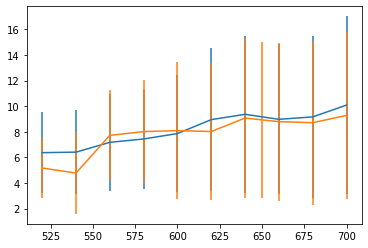

In [117]:
plt.errorbar(flat_duties, flat_dr_mean, flat_dr_std)
plt.errorbar(dimpled_duties, dimple_dr_mean, dimple_dr_std)